In [1]:
%load_ext autoreload

In [9]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.integrate import odeint
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import simulate_vdp, compute_EDMD, compute_VAR_p, construct_dictionary, perform_stability_analysis, get_stability_results, predict_EDMD, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# VDP Signal

In [12]:
dt = 0.001
total_time = 3000
mu_vals=np.array([0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5])
method = 'scipy'
subsample = False
verbose = 2
signals, taus, delayed_mis = simulate_vdp(dt, total_time, mu_vals, method, subsample, verbose)

  0%|          | 0/12 [00:00<?, ?it/s]

# VDP Signal

In [15]:
def vdp_jacobian(pt, mu):
    x, y = pt[0], pt[1]
    return np.array([[0, 1], [-2*mu*x*y - 1, mu - mu*(x**2)]])

In [97]:
def compute_lyaps(Js, verbose=False):
    T, n = Js.shape[0], Js.shape[1]
    old_Q = np.eye(n)
    lexp = np.zeros(n)
    lexp_counts = np.zeros(n)
    for t in tqdm(range(T), disable=not verbose):
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

    return np.divide(lexp, lexp_counts)

In [119]:
# for mu in mu_vals:
max_ind = int(1e6)
lyapunov_exps = {}
for mu in mu_vals:
# for mu in [5.0]:
    key = f"mu = {mu}"
    print("-"*20)
    print(key)
    print("-"*10)
    vdp_sig = signals[key]
    signal = vdp_sig
    
    js = np.zeros((np.min([signal.shape[0], max_ind]), signal.shape[1], signal.shape[1]))
    for i, pt in tqdm(enumerate(signal[:np.min([signal.shape[0], max_ind])]), total=np.min([signal.shape[0], max_ind])):
        js[i] = vdp_jacobian(pt, mu)*dt_sim + np.eye(2)
    
    lexp = compute_lyaps(js, verbose=True)
    lexp /= dt
    
    lyapunov_exps[key] = lexp

--------------------
mu = 0.001
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 0.01
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 0.1
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 0.2
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 0.5
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 0.75
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 1.0
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 1.25
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 2.0
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 3.0
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 4.0
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

--------------------
mu = 5.0
----------


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [112]:
def lambda_2(mu):
    if mu < 2:
        return -mu  - (1/16)*(mu ** 3) + (263/18432)*(mu ** 5)
    elif mu >= 2 and mu <= 4:
        return (-1.2 + (mu - 2)*(-0.1))*mu
    elif mu > 4 and mu <= 5:
        return (-1.4 + (mu - 4)*(-0.05))*mu
#     elif mu == 2:
#         return -1.2*mu
#     elif mu == 3:
#         return -1.3*mu
#     elif mu == 4:
#         return -1.4*mu
#     elif mu == 5:
#         return -1.45*mu
    else:
        return None
# https://arxiv.org/pdf/2111.12198.pdf

lambda_2(mu)

-7.25

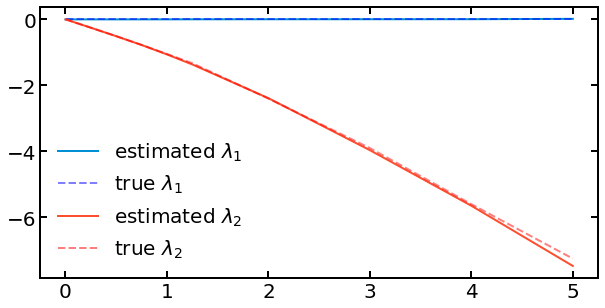

In [127]:
plt.plot(mu_vals, [lyapunov_exps[f"mu = {mu}"][0] for mu in mu_vals], label=r'estimated $\lambda_1$')
plt.plot(mu_vals, np.zeros(len(mu_vals)), linestyle='--', c='blue', alpha=0.5, label=r'true $\lambda_1$')
plt.plot(mu_vals, [lyapunov_exps[f"mu = {mu}"][1] for mu in mu_vals], label=r'estimated $\lambda_2$')
plt.plot(mu_vals, [lambda_2(mu) for mu in mu_vals], linestyle='--', c='red', alpha=0.5, label=r'true $\lambda_2$')
plt.legend()
plt.show()